# Imports

In [118]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os
from sklearn.neighbors import KernelDensity

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# Simulation constants

In [199]:
neurons_per_pop = 10
n_pop = 3
gaussian_factor = 15
delete_factor = 3
bandwidth = 2
noise_factor = 3
exc = [[1], [2], [1]]
inh = [[], [0], [0]]
n_batches = 300
T = 100

<AxesSubplot:title={'center':'$U$'}>

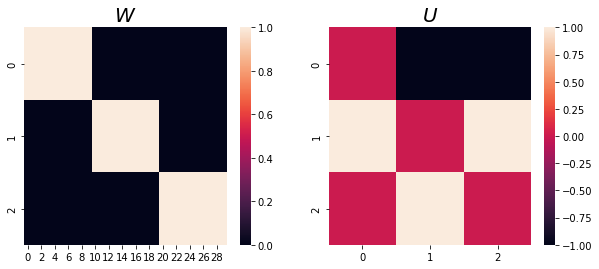

In [223]:
U = [[0, -1, -1],
    [1, 0, 1],
    [0, 1, 0]]

W = [[1, 0, 0], [1, 0, 0],[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0],
    [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0],
    [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]

U = torch.tensor(U)
W = torch.tensor(W).T

plot_weights(W, U)

# Create data

In [200]:
# time array
t = np.arange(0, T)

# data tensor
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)

# empty popuations input array
fr = np.zeros((n_pop, T, n_batches))

for batch in range(n_batches):
    
    spikes = np.zeros((neurons_per_pop*n_pop, T))
    mothers = np.zeros((n_pop, T))
    
    for pop in range(n_pop):
        # create a random gaussian-peaked function with random number of peaks
        n_peaks = np.random.randint(low=15, high=40)
        peak_locations = np.random.randint(low=0, high=T, size=(n_peaks))
        kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(peak_locations[:, None])
        gausfit = kde.score_samples(t[:, None])

        # create spike train based on random gaussian-peaked function
        fr[pop, :, batch] = gaussian_factor*np.exp(gausfit)
        mothers[pop, :] = np.random.poisson(lam=fr[pop, :, batch])

    for pop in range(n_pop):
        delete_spikes = np.roll(delete_factor*np.sum(fr[inh[pop], :, batch], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(noise_factor*np.sum(fr[exc[pop], :, batch], 0), 1), (neurons_per_pop, T))
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = np.tile(mothers[pop, :], (neurons_per_pop, 1))- delete_spikes + noise
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1

    data[:, :, batch] = torch.tensor(spikes)

<AxesSubplot:title={'center':'Spiking pattern'}, xlabel='time', ylabel='# neuron'>

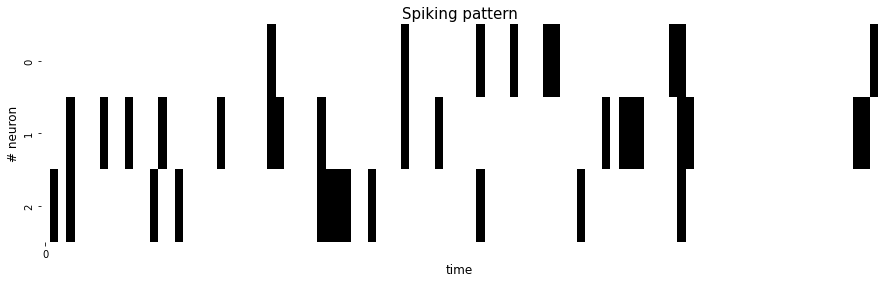

In [201]:
raster_plot(mothers)

Text(0.5, 0, 'time')

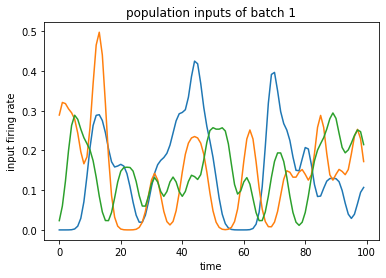

In [202]:
for pop in range(n_pop):
    plt.plot(t, fr[pop, :, 0])

plt.title('population inputs of batch 1')
plt.ylabel('input firing rate')
plt.xlabel('time')

<AxesSubplot:title={'center':'Spiking pattern of batch 1'}, xlabel='time', ylabel='# neuron'>

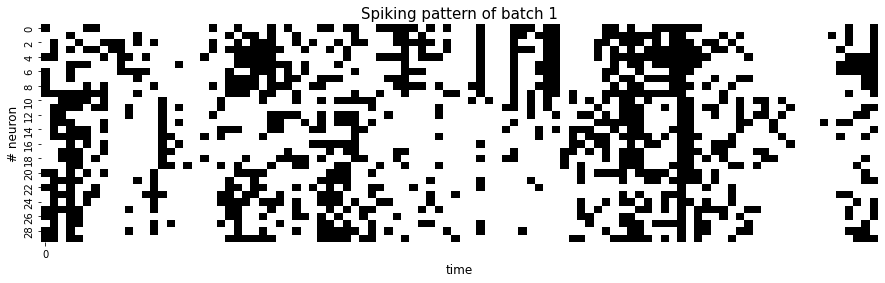

In [203]:
raster_plot(data[:, :, -1], title='Spiking pattern of batch 1')

In [204]:
torch.mean(data)

tensor(0.3324)

# Train RTRBM

In [209]:
rtrbm = RTRBM(data, N_H=3, device='cpu')

### 500 epochs

In [210]:
rtrbm.learn(n_epochs=500, batchsize=10, lr=1e-3, mom=.7, wc=.0002)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:16:42<00:00,  9.21s/it]


<AxesSubplot:title={'center':'Reconstruction error of RTRBM during training'}, xlabel='epochs', ylabel='normalised reconstruction error'>

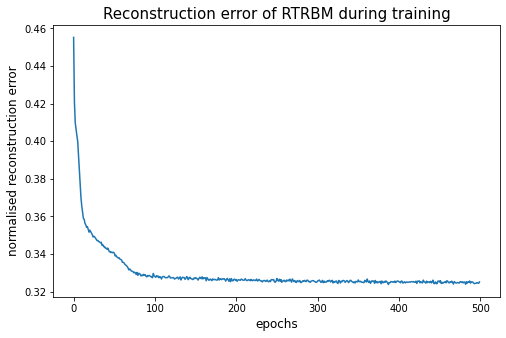

In [211]:
plot_reconstruction_error(rtrbm.errors)

<AxesSubplot:title={'center':'$U$'}>

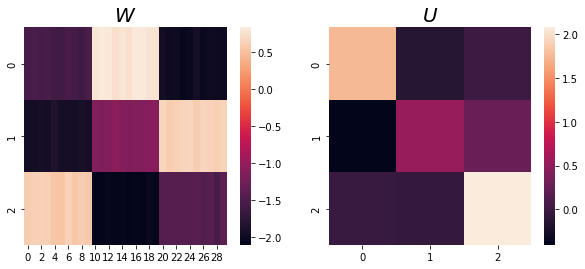

In [212]:
plot_weights(rtrbm.W.cpu(), rtrbm.W_acc.cpu())

<AxesSubplot:xlabel='x', ylabel='y'>

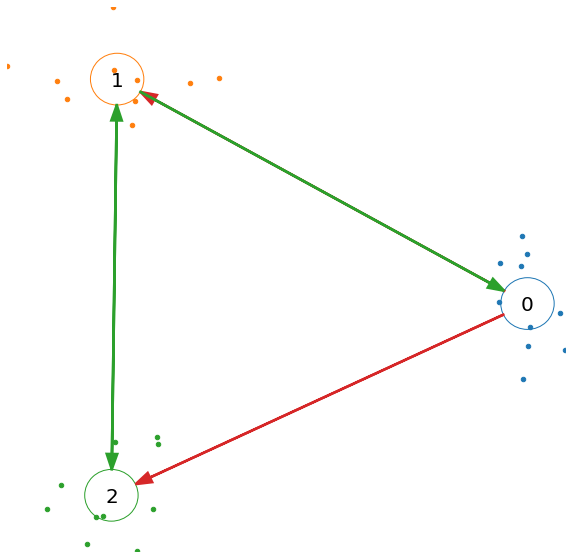

In [231]:
plot_hidden_structure(W, U, n_pop=3, only_max_conn=True, weight_line_factor=0.4, hiddens_radius=.1)

<AxesSubplot:xlabel='x', ylabel='y'>

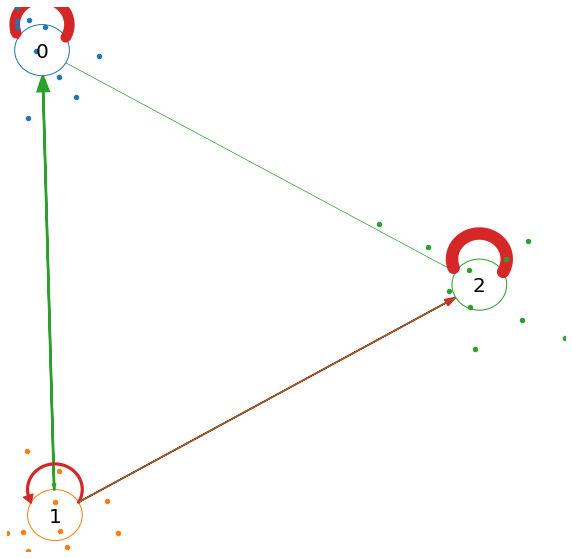

In [237]:
plot_hidden_structure(rtrbm.W.cpu(), -rtrbm.W_acc.cpu(), n_pop=3, only_max_conn=False, hiddens_radius=.1)

### 300 extra epochs

In [155]:
rtrbm.learn(n_epochs=100, batchsize=30, mom=0, wc=0, lr=1e-4)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:44<00:00,  7.64s/it]


<AxesSubplot:title={'center':'Reconstruction error of RTRBM during training'}, xlabel='epochs', ylabel='normalised reconstruction error'>

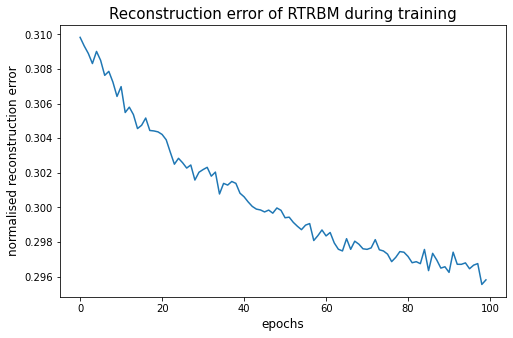

In [156]:
plot_reconstruction_error(rtrbm.errors)

<AxesSubplot:title={'center':'$U$'}>

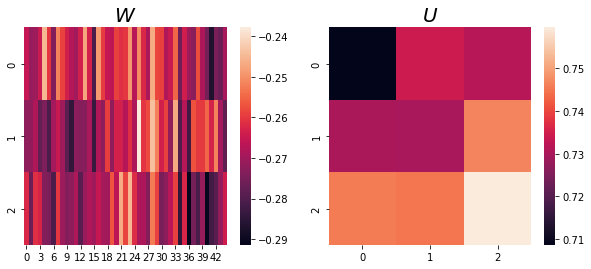

In [157]:
plot_weights(rtrbm.W.cpu(), rtrbm.W_acc.cpu())

RTRBM only connects to first population

### 100 extra epochs

In [83]:
rtrbm.learn(n_epochs=100, batchsize=30, mom=0, wc=0, lr=5e-5, CDk=10)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:18<00:00,  9.19s/it]


<AxesSubplot:title={'center':'Reconstruction error of RTRBM during training'}, xlabel='epochs', ylabel='normalised reconstruction error'>

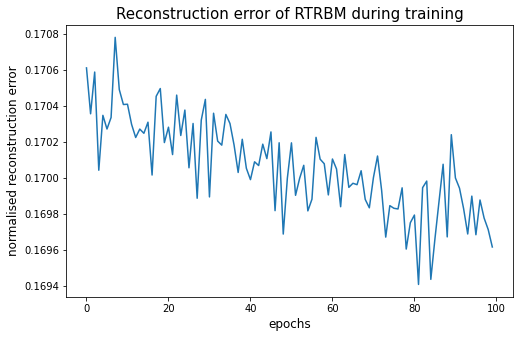

In [84]:
plot_reconstruction_error(rtrbm.errors)

<AxesSubplot:title={'center':'$U$'}>

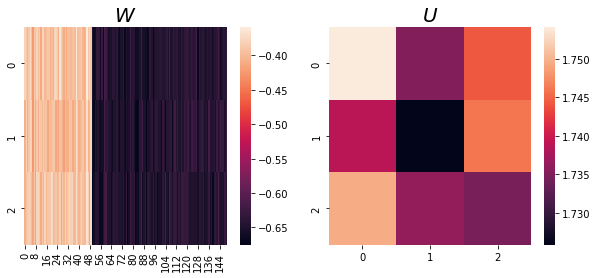

In [85]:
plot_weights(rtrbm.W.cpu(), rtrbm.W_acc.cpu())

<AxesSubplot:xlabel='x', ylabel='y'>

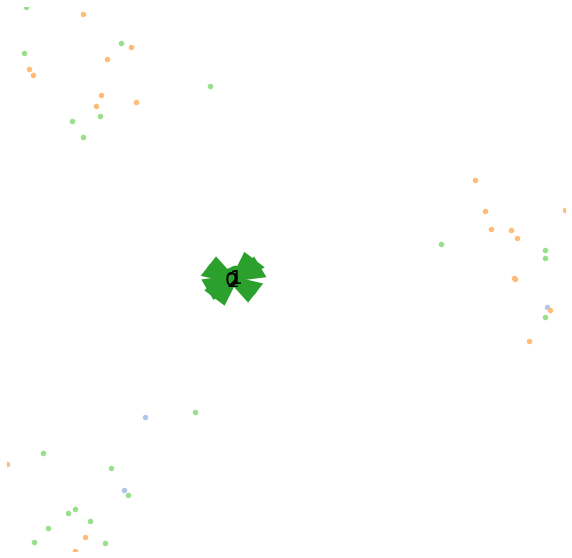

In [163]:
plot_hidden_structure(-rtrbm.W.cpu(), rtrbm.W_acc.cpu(), n_pop=3, only_max_conn=False)

In [128]:
rtrbm.learn(n_epochs=100, batchsize=20, mom=0, wc=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:43<00:00,  3.43s/it]


<AxesSubplot:title={'center':'$U$'}>

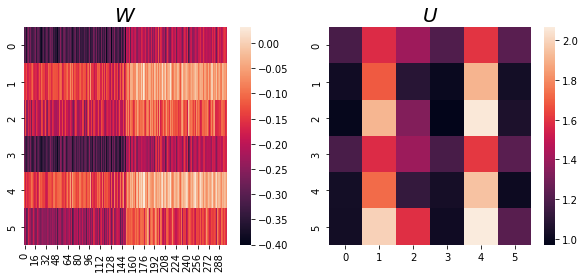

In [129]:
plot_weights(rtrbm.W.cpu(), rtrbm.W_acc.cpu())

In [162]:
import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch



def plot_hidden_structure(VH,
                          HH,
                          rf=None,
                          coords=None,
                          n_pop=10,
                          markersize_visibles=20,
                          hiddens_radius=0.02,
                          weight_line_factor=1,
                          hidden_weight_thresh=0,
                          only_max_conn=True,
                          axis_off=True,
                          figsize=(10,10)):

    if coords is None:
        neurons_per_pop = VH.shape[1] // n_pop
        rads = torch.linspace(0, 2 * torch.pi, n_pop + 1)
        mean_locations_pop = torch.zeros(n_pop, 2)
        coordinates = torch.zeros(neurons_per_pop * n_pop, 2)
        for i in range(n_pop):
            mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
            coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + \
                                                                            mean_locations_pop[i]
        coords = coordinates

    if rf is None:
        rf = get_hidden_mean_receptive_fields(VH, coords, only_max_conn=only_max_conn)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]

    N_H = HH.shape[0]
    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h],
                                             x_hidden_mean_receptive_fields[hh], y_hidden_mean_receptive_fields[hh],
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h],
                                             x_hidden_mean_receptive_fields[hh], y_hidden_mean_receptive_fields[hh],
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    if axis_off:
        plt.axis('off')
    return plt.gca()



def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(12, 9))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]

    N_H = HH.shape[0]
    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.xlabel('x', fontsize=28)
    plt.ylabel('y', fontsize=28)
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.show()



def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    plt.gca().text(x, y-0.03, str(id), ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
        drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow
    else:
        plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                        neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                        lw=3 * linewidth, color=color, length_includes_head=True, head_width=linewidth/20, overhang=0)

def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(RegularPolygon((endX, endY + radius / 2),  # (x,y)
                                    3,  # number of vertices
                                    radius / 9,  # radius
                                    rad(angle_ + theta2_),  # orientation
                                    color=color_))


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)
        ax.set_xlabel('x', fontsize=28)
        ax.set_ylabel('y', fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
def get_hidden_mean_receptive_fields(weights, coordinates, only_max_conn=False):

    VH = weights.detach().clone()

    if only_max_conn is False: VH[VH < 0] = 0

    n_dimensions = torch.tensor(coordinates.shape).shape[0]
    N_H = VH.shape[0]

    max_hidden_connection = torch.max(VH, 0)[1]
    if n_dimensions == 1:
        rf = torch.zeros(N_H)
        for h in range(N_H):
            if only_max_conn:
                v_idx = (max_hidden_connection == h)
                rf[h] = torch.mean(coordinates[v_idx])
            else:
                rf[h] = torch.sum(VH[h, :] * coordinates / torch.sum(VH[h, :]))
    else:
        rf = torch.zeros(N_H, n_dimensions)
        for i in range(n_dimensions):
            for h in range(N_H):
                if only_max_conn:
                    v_idx = (max_hidden_connection == h)
                    rf[h, i] = torch.mean(coordinates[v_idx, i])
                else:
                    rf[h, i] = torch.sum(VH[h, :] * coordinates[:, i] / torch.sum(VH[h, :]))

    return rf

